# Basic Tutorial for GEORGE

In this notebook, we demonstrate a simple experiment comparing empirical risk minimization (ERM) and our method (GEORGE) on the MNIST dataset, using a small three-layer CNN model. In this simple example, GEORGE improves worst-case accuracy (i.e., the minimum accuracy over any subclass) compared to ERM. More sophisticated experiments are described in the blog post (and paper, coming soon). The notebook can be run with or without GPU support. For a script version rather than a notebook, see `stratification/run.py`.

There are four main sections to this notebook:
1. **Setup**: Imports and setting up the dataset and model.
2. **Train ERM Model**: we train an empirical risk minimization (ERM) model on the `superclass` labels.
3. **Cluster Activations**: using the feature representation of the ERM model, we leverage dimensionality reduction and clustering techniques in order to estimate approximate `subclass` labels for each example.
4. **Train "GEORGE" Model**: we train a new model that exploits the recovered `subclass` labels to improve worst-case performance on them, using group distributionally robust optimization (GDRO) \[[Sagawa et al. (2020)](https://arxiv.org/abs/1911.08731)\].

## 1. Setup

### 1.1 Imports and configuration setup
Before you start, make sure you have set up the repository correctly and installed all dependencies, as described in the README.

All training options are handled by a single `config` object. In this tutorial, we use the configuration provided in `demo_config.json`. To see how configuration files are defined, validated, and optionally modified via the command line, check out `stratification/utils/parse_args.py` and `stratification/utils/schema.py`.

In [1]:
import json
import os
import torch

from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from pathlib import Path
from stratification.harness import GEORGEHarness
from stratification.utils.utils import set_seed, init_cuda
from stratification.utils.parse_args import get_config
from stratification.cluster.models.cluster import GaussianMixture
from stratification.cluster.models.reduction import UMAPReducer

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# repository base directory
os.chdir('../')
REPO_DIR = os.getcwd()

with open('configs/celeba_george_config.json', 'r') as f:
    config = json.dumps(json.load(f))
config = get_config([config])

os.chdir(os.path.join(REPO_DIR, 'stratification'))

use_cuda_if_available = True  # change to True if you want to use CUDA
use_cuda = use_cuda_if_available and torch.cuda.is_available()
# set seeds for reproducibility
set_seed(config['seed'], use_cuda)
# initialize CUDA, if available
init_cuda(config['deterministic'], config['allow_multigpu']);

['{"exp_dir": "checkpoints/celebA", "dataset": "celeba", "mode": "george", "seed": 0, "allow_multigpu": true, "classification_config": {"model": "resnet50", "checkpoint_metric": "val_acc", "bit_pretrained": true, "optimizer_config": {"class_args": {"lr": 1e-05, "weight_decay": 0.1, "momentum": 0.9}, "class_name": "SGD"}, "workers": 8, "criterion_config": {}, "eval_only": false, "metric_types": ["loss", "acc"], "num_epochs": 50, "batch_size": 128, "scheduler_config": {"class_args": {"milestones": []}, "class_name": "MultiStepLR"}, "gdro_config": {"checkpoint_metric": "val_subclass_rob_acc", "bit_pretrained": false, "optimizer_config": {"class_args": {}}, "criterion_config": {"size_adjustment": 3}, "uniform_group_sampling": true}, "dataset_config": {}}, "reduction_config": {"model": "none"}, "cluster_config": {"model": "kmeans", "metric_types": ["mean_loss", "composition"], "search_k": true, "overcluster": true, "sil_cuda": true}}']
ArgumentParser(prog='ipykernel_launcher.py', usage=None

### 1.2. Initialize GEORGEHarness

The `GEORGEHarness` is an object that handles the "bookkeeping" for each of the steps outlined in this tutorial, such as setting up experiment directories and loading/saving models.  Experiment files are stored in the base directory specified by `config['exp_dir']`. Each experiment run is stored in a subdirectory of this base directory whose filename is based on the (1) training method (ERM, GEORGE, etc.), (2) the timestamp, and (3) a random hash (to avoid collisions).

In [2]:
harness = GEORGEHarness(config, use_cuda=use_cuda, log_format='simple')

### 1.3 Get Data and Model Architecture

In this tutorial, we'll use the MNIST dataset. In our case, the task will be to classify digits as < 5 or ≥ 5; these correspond to the two *superclasses*. The *subclasses* are the individual digits (0,1,2,3,4 are the subclasses of the first superclass, and 5,6,7,8,9 are the subclasses of the second superclass).

When fetching the dataloaders and NN architecture, we can also specify the "mode" (training method), as one can specify different data and model options in the configuration for the different training methods.

Additional datasets and architectures can be added under `stratification/classification/datasets` and `stratification/classification/models`, respectively.

In [3]:
dataloaders = harness.get_dataloaders(config, mode='erm')
num_classes = dataloaders['train'].dataset.get_num_classes('superclass')
model = harness.get_nn_model(config, num_classes=num_classes, mode='erm')

/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True


/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/data
/Users/Jen/Documents/UT Austin/Research/hidden-strat

  0%|          | 0/273071896 [00:00<?, ?it/s]

## 2. Train ERM Model

We've already initialized our model, a simple CNN architecture. Let's print it out:

In [4]:
print('Model architecture:')
print(model)

Model architecture:
ResNetV2(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32,

Now, we're ready to train a classifier! First we'll just train a standard classifier using empirical risk minimization (a fancy term for minimizing the average training loss). We'll print out both the overall accuracy and the true robust accuracy (i.e., the minimum accuracy on any subclass), along with the losses as well. The robust accuracy is the metric we are interested in maximizing. We train our models as though we don't know the subclass (digit) labels, in which case we can't actually measure the true robust accuracy. In reality, we do know the subclass labels for this dataset, so we'll measure per-subclass performance to see how well each method *really* does.

In [5]:
erm_dir = harness.classify(config['classification_config'],  model, dataloaders, 'erm')

Config saved in: checkpoints/celebA/run_2023-11-04_11-48-41_039bb114/erm_2023-11-04_11-49-03_b5f493eb
Evaluating on train split...
Evaluating on val split...
Evaluating on test split...


The overall test accuracy is around **92%**, but the robust accuracy is quite a bit lower at around **82%**. (Note: Results may vary based on random seed, platform, GPU use, etc.) Let's see if we can improve on this!

## 3. Cluster Model Activations

Now, we'll cluster the data of each superclass, to try and automatically identify the subclasses. However, just clustering the raw data usually doesn't work that well - instead, we cluster in the *feature space* of a trained model. We just trained an ERM model on the task, so we'll now use this model to extract features which we use for clustering. Specifically, the features are the activations (outputs) of the penultimate layer (right before the classification layer).

### 3.1. Initialize Cluster Model and Reduction Model

The clustering procedure consists of two steps:
1. Dimensionality reduction of the activations (optional). If `reduction_model` is `None`, the raw activations are used.
2. Fitting a separate cluster model on the reduced training activations of each superclass.

We'll use UMAP for dimensionality reduction, and we'll use Gaussian mixture model clustering. For simplicity, in this tutorial we fix the number of clusters per superclass to 5 (the true number of subclasses per superclass for this task). *Automatic* selection of the number of clusters based on unsupervised metrics (such as the Silhouette score) is also supported - in fact, our experiments in the blog post and paper are run using this automatic selection procedure, rather than pre-specifying the number of clusters.

In [6]:
# Dimensionality reduction model
reduction_model = UMAPReducer(random_state=12345, n_components=2)
# Clustering model
cluster_model = GaussianMixture(covariance_type="full", n_components=5, n_init=3)

### 3.2. Run `harness.reduce`

Now, we use UMAP to dimensionality-reduce the activations to produce the "features" that we'll cluster.

In [7]:
reduction_dir = harness.reduce(config['reduction_config'], reduction_model,
                               inputs_path=os.path.join(erm_dir, 'outputs.pt'))

Config saved in: checkpoints/celebA/run_2023-11-04_11-48-41_039bb114/erm_2023-11-04_11-49-03_b5f493eb/reduce_2023-11-06_00-25-27_94256a98
Fitting reduction model on superclass 0...


/usr/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fitting reduction model on superclass 1...


/usr/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### 3.3. Run `harness.cluster`

Now, we cluster the aforementioned features.

In [8]:
# Now, we cluster the features separately for each superclass.
# This step also generates and saves visualizations of the data, which we'll look at in the next part.
cluster_dir = harness.cluster(config['cluster_config'], cluster_model,
                              inputs_path=os.path.join(reduction_dir, 'outputs.pt'));

Config saved in: checkpoints/celebA/run_2023-11-04_11-48-41_039bb114/erm_2023-11-04_11-49-03_b5f493eb/reduce_2023-11-06_00-25-27_94256a98/cluster_2023-11-06_00-29-12_8859317b
Clustering superclass 0...
Clustering superclass 1...


<Figure size 640x480 with 0 Axes>

### 3.4. Visualizing the clusters

Now let's look at the clusters that we found. Since we apply UMAP to reduce to dimension 2, we can directly visualize the data in this two-dimensional "feature space" - see below! The first row corresponds to the first superclass (< 5, i.e. digits 0-4) and the second row corresponds to the second superclass (≥ 5, i.e. digits 5-9). On the left, we color each point by its assigned cluster label. On the right, we color each point by its actual subclass (i.e., which digit that datapoint is). As we can see, the individual subclasses are fairly easy to distinguish in feature space, and as a result *up to permutation* the clusters we find match up quite well with the actual subclasses.

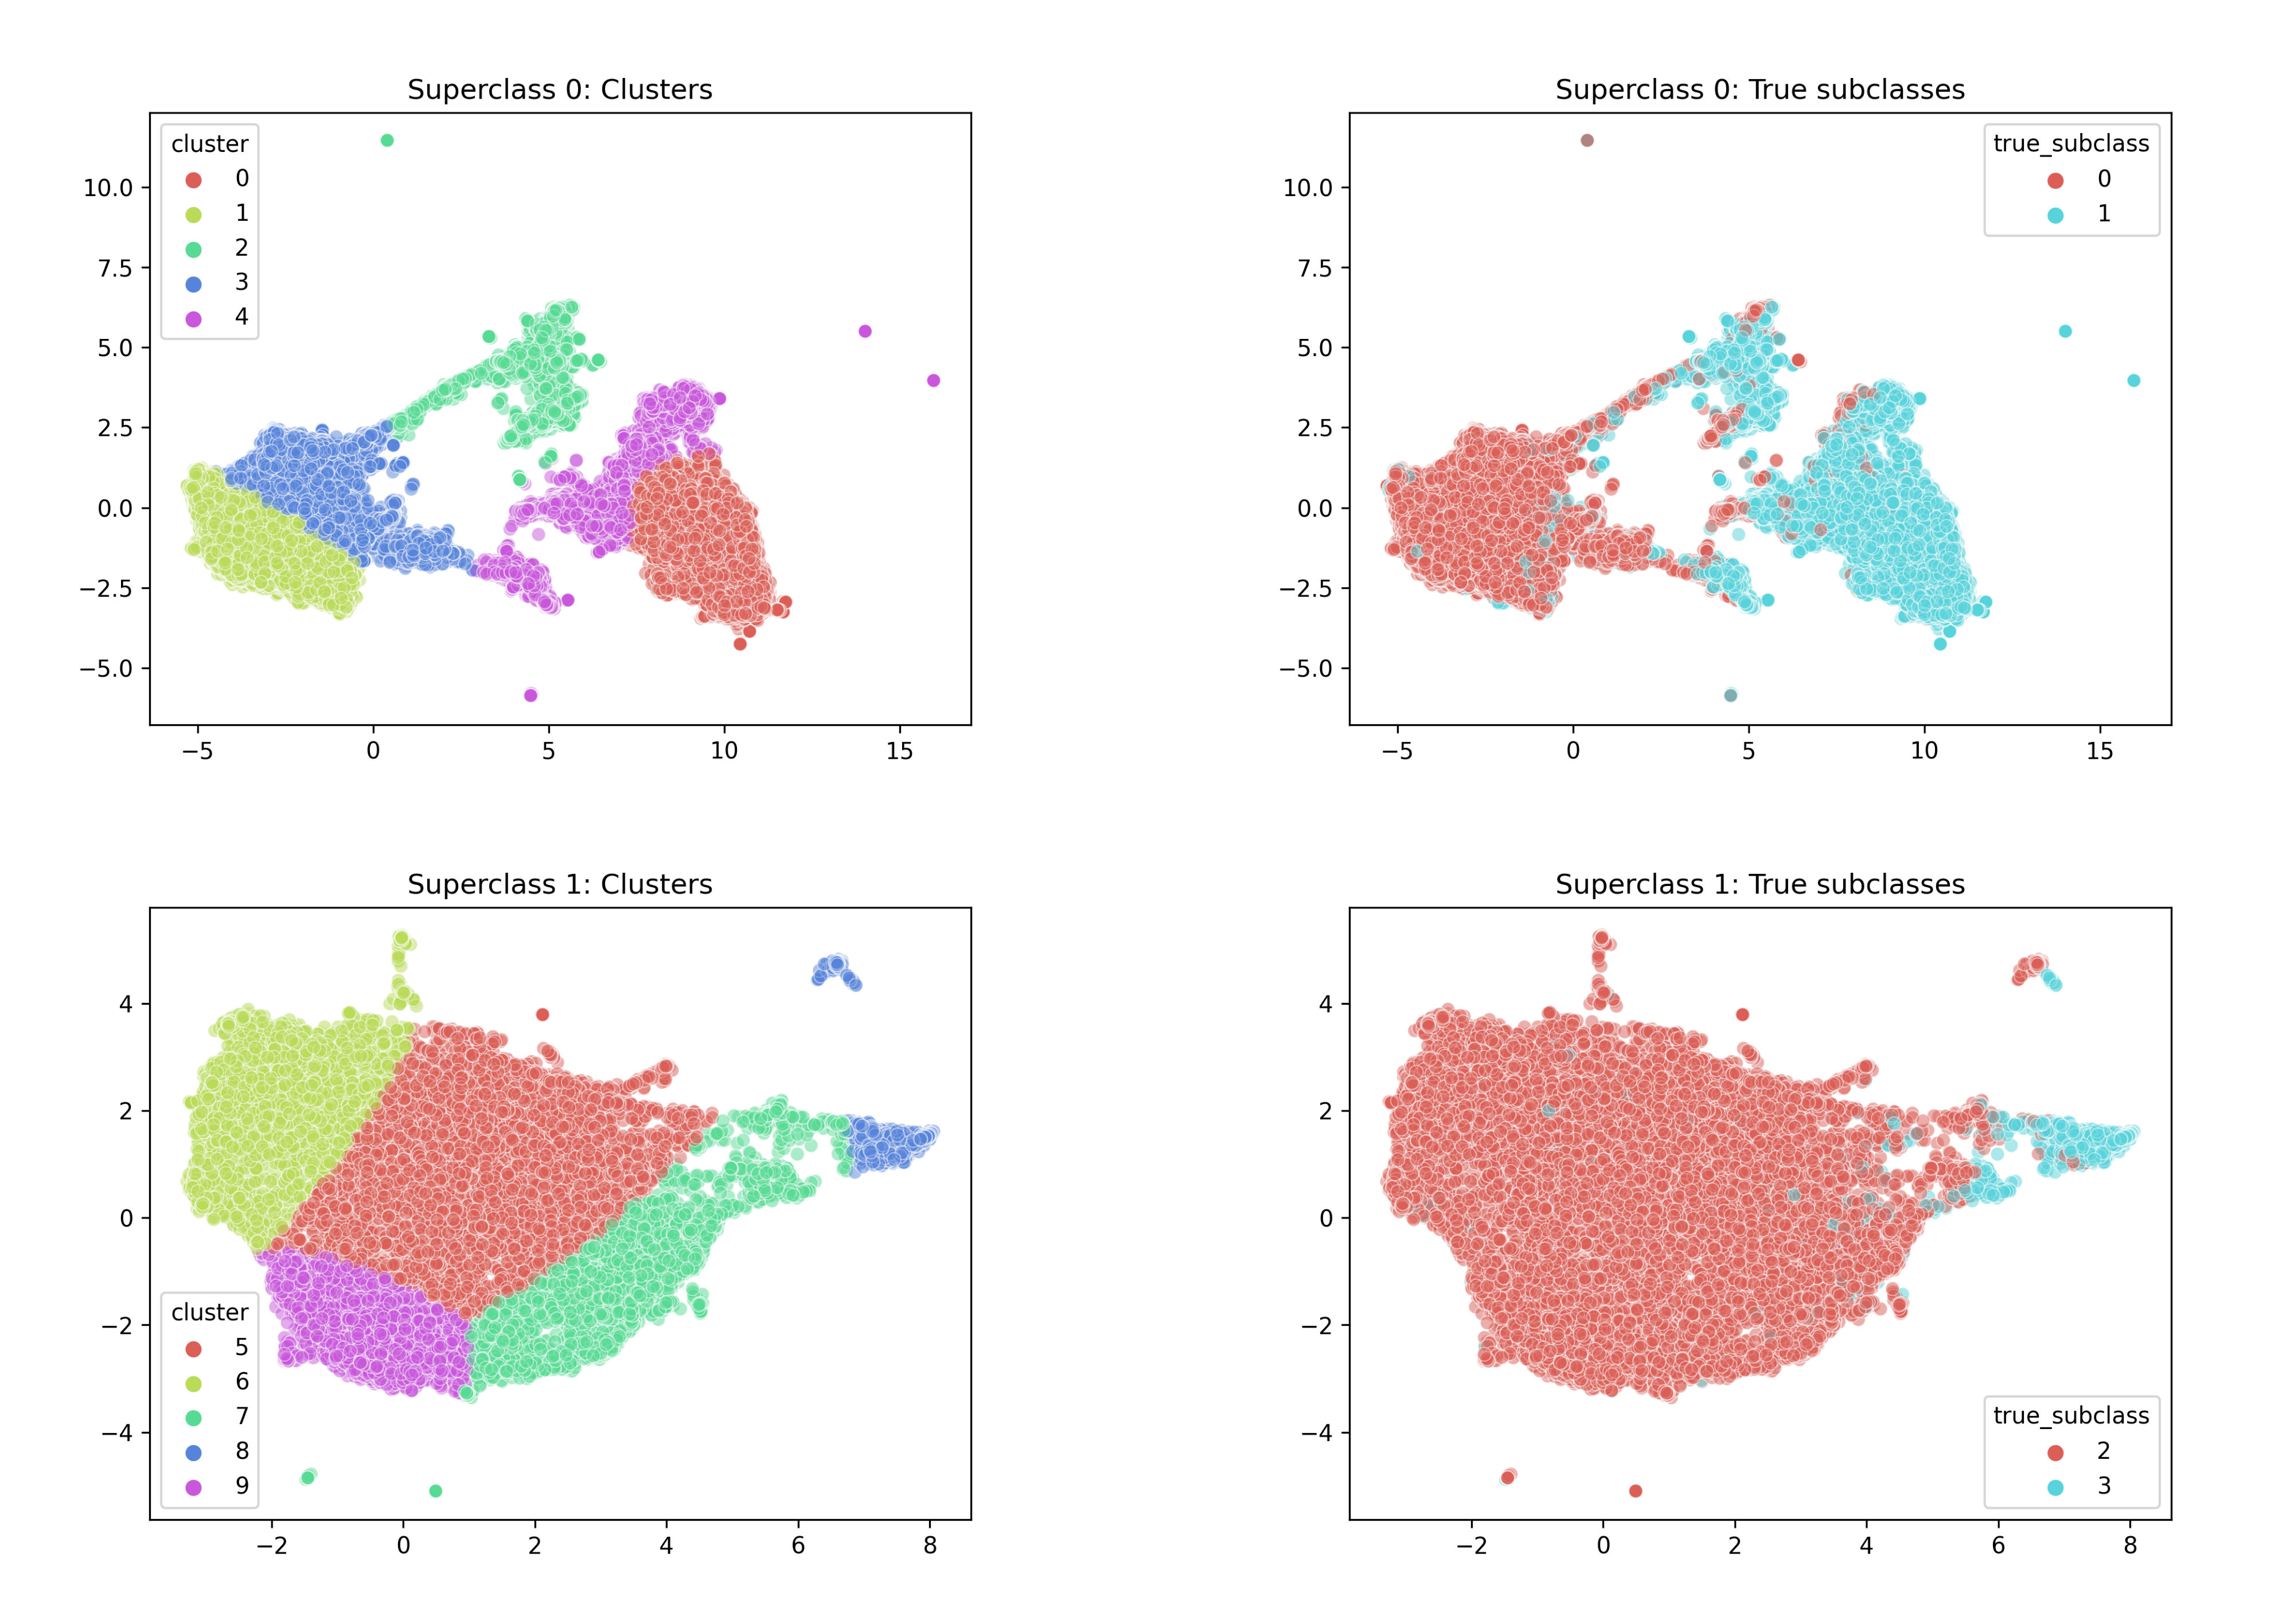

In [9]:
viz_dir = os.path.join(cluster_dir, 'visualizations')
fig, axarr = plt.subplots(2, 2, figsize=(18, 12), gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True, dpi=300)
for i in range(2):
    axarr[i, 0].imshow(mpimg.imread(os.path.join(viz_dir, f'train/group_{i}_cluster_viz.png')))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(os.path.join(viz_dir, f'train/group_{i}_true_subclass_viz.png')))
    axarr[i, 1].axis('off')

## 4. Train Final (GEORGE) Model

Training the GEORGE model is simple. The only new thing to pass in is the `clusters.pt` path. This is a pickled dictionary saved by `harness.cluster` that contains the cluster labels assigned to the datapoints. These estimated cluster labels are used as a surrogate for the subclass labels. We now train a model to minimize the *worst-case* loss over the clusters using GDRO. Since the cluster assignments are similar to the true subclass labels up to permutation, we expect that this procedure should also improve worst-case accuracy on the true subclasses.

As before, we'll print out both the overall accuracy and true robust accuracy. We'll also print out the *estimated* robust accuracy, which is the minimum accuracy on any *cluster*. Unlike the true robust accuracy, this is something we can actually measure even when we don't know the true subclass labels. If the cluster labels are a good estimate of the true subclass labels, then this estimated robust accuracy should be a good estimate of the true robust accuracy.

In [10]:
set_seed(config['seed'], use_cuda)  # reset random state
# Specify path to estimated subclass labels
dataloaders = harness.get_dataloaders(
    config, mode='george', subclass_labels=os.path.join(cluster_dir, 'clusters.pt'))
# Initialize new model
model = harness.get_nn_model(config, num_classes=num_classes, mode='george')

# Train the final (GEORGE) model
george_dir = harness.classify(config['classification_config'], model, dataloaders,
                              mode='george')

/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
data
/Users/Jen/Documents/UT Austin/Research/hidden-stratification
hii /Users/Jen/Documents/UT Austin/Research/hidden-stratification/data/celebA/img_align_celeba
True
True
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/stratification
/Users/Jen/Documents/UT Austin/Research/hidden-stratification/data
/Users/Jen/Documents/UT Austin/Research/hidden-strat

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/Jen/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Config saved in: checkpoints/celebA/run_2023-11-04_11-48-41_039bb114/george_2023-11-06_00-29-39_8c3ea304
Starting training.

Epoch: [1 | 50] LR: 1.00E-05
Training:


/usr/local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Loss: 0.605, Acc.: 79.18%, Est. rob. loss: 0.619, Est. rob. acc: 65.53%, True rob. loss: 0.632, True rob. acc: 65.94%
Validation:
Loss: 0.413, Acc.: 79.86%, Est. rob. loss: 0.548, Est. rob. acc: 72.74%, True rob. loss: 0.537, True rob. acc: 74.12%

Epoch: [2 | 50] LR: 1.00E-05
Training:
Loss: 0.457, Acc.: 87.04%, Est. rob. loss: 0.510, Est. rob. acc: 75.86%, True rob. loss: 0.452, True rob. acc: 82.59%
Validation:
Loss: 0.302, Acc.: 83.92%, Est. rob. loss: 0.459, Est. rob. acc: 77.82%, True rob. loss: 0.424, True rob. acc: 81.57%

Epoch: [3 | 50] LR: 1.00E-05
Training:


The overall accuracy is similar to that of the ERM model, but the robust accuracy has improved to around **89%**!
In addition, our estimate of the robust accuracy (**91%**) is quite close to the actual robust accuracy (and these two metrics remain close throughout the entire training run).
Again, results may vary somewhat - but on average across random seeds, the GEORGE model outperforms the ERM model in terms of robust accuracy.

## Conclusion

This notebook demonstrates our framework (GEORGE) for estimating subclasses and improving worst-case subclass accuracy, on a simple "toy" example. Although the end-to-end performance gains are modest in this case, on more complex datasets the gains can be quite dramatic! See our blog post and paper for more details.

In [ ]:
# notebook_login()

In [ ]:
# model_id = "celeba-george-classifier-01" #@param {type:"string"}

# description = """
# Autogenerated by HuggingPics🤗🖼️

# Create your own image classifier for **anything** by running [the demo on Google Colab](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb).

# Report any issues with the demo at the [github repo](https://github.com/nateraw/huggingpics).
# """
# task_name = "Image Classification"
# task_type = 'image-classification'
# metric_name = 'Accuracy'
# metric_type = 'accuracy'
# metric_value = trainer.callback_metrics['val_acc'].item()

# # Delete model folder, as we (re)create it here.
# if Path('./model').exists():
#     shutil.rmtree('./model')

# token = HfFolder().get_token()
# if not token:
#     raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

# hf_username = HfApi().whoami()['name']
# model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
# model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
# model.save_pretrained(model_repo.local_dir)
# feature_extractor.save_pretrained(model_repo.local_dir)

# # Copy over tensorboard logs from lightning_logs/ into ./model/runs/
# tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
# model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
# model_repo_logs_path.mkdir(exist_ok=True, parents=True)
# shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# # Copy over a few example images
# example_images_dir = Path(model_repo.local_dir) / 'images'
# example_images_dir.mkdir(exist_ok=True, parents=True)
# image_markdown_template = '''
# #### {class_name}

# ![{class_name}](images/{example_image_path})
# '''

# # Prepare README.md from information gathered above
# readme_txt = f"""
# ---
# tags:
# - pytorch
# metrics:
# - {metric_type}

# model-index:
# - name: {model_id}
#   results:
#   - task:
#       name: {task_name}
#       type: {task_type}
#     metrics:
#       - name: {metric_name}
#         type: {metric_type}
#         value: {metric_value}
# ---

# # {model_id}

# {description}

# """.strip()

# (Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

# commit_url = model_repo.push_to_hub()

# print("Check out your model at:")
# print(f"https://huggingface.co/{hf_username}/{model_id}")